# TP 5 : Hawkes Processes
Camille BROSETTE  
Maxime LEGRAND

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
%matplotlib inline
import matplotlib.pylab as plt
from datetime import datetime

## I. One-dimensional Hawkes processes

In [2]:
# Global settings
seed1=1337
T1=100
mu1=1.2
alpha1=0.6
beta1=0.8

### Functions

In [3]:
def lambdaFun(t, mu=mu1, alpha=alpha1, beta=beta1, t_l=[]):
    t_l = [ti for ti in t_l if ti < t]
    return mu+np.array([alpha*np.exp(-beta*(t-ti)) for ti in t_l]).sum()

In [4]:
def simHawkes(ls=1, T=T1, mu=mu1, alpha=alpha1, beta=beta1, seed=seed1):
    np.random.seed(seed)
    res = [0]
    u = np.random.uniform()
    s = -np.log(u)/ls
    if (s >= T):
        return res
    res += [s]
    while (True):
        # Routine
        ls = lambdaFun(s, mu=mu, alpha=alpha, beta=beta, t_l=res) + alpha
        test = True
        while test:
            u = np.random.uniform()
            s += -np.log(u)/ls
            if (s >= T):
                return res
            # Rejection test
            D = np.random.uniform()
            test = (D > lambdaFun(s, mu=mu, alpha=alpha, t_l=res)/ls)
        res += [s]

**Remarques :**
 - `ls` $=\lambda^*$
 - `simHawkes().[i]` $=t_i$.

### Corresponding curves

In [5]:
# Hawkes process
Proc1 = simHawkes()
# Corresponding intensity
Int1 = [lambdaFun(t=Proc1[i], t_l=Proc1) for i in range(len(Proc1))]

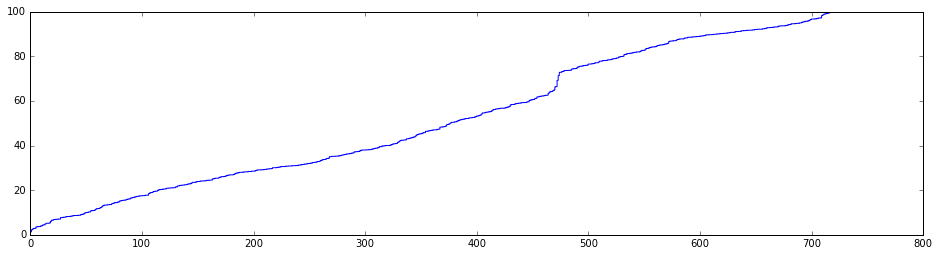

In [6]:
# Plotting Proc1
f, ax = plt.subplots(figsize=(16,4))
ax.step(np.arange(0,len(Proc1)), Proc1)
plt.show()

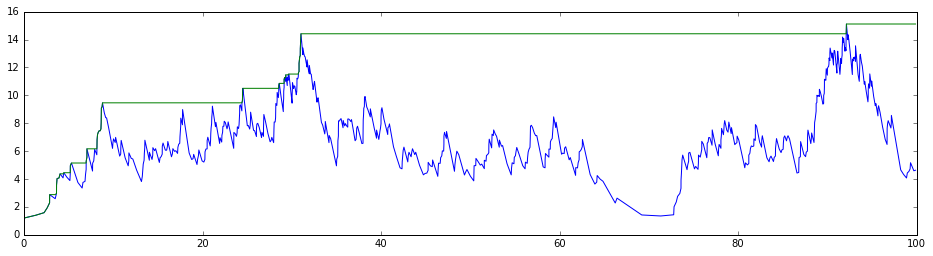

In [7]:
# Plotting Int1 against Proc1
f, ax = plt.subplots(figsize=(16,4))
ax.plot(Proc1, Int1)
ax.plot(Proc1, pd.Series(Int1).cummax())
plt.show()

### Testing the simulated process with $\Lambda(t_i,t_{i+1})=\tau_{i+1}-\tau_i$

In [8]:
def AFun(t, beta=beta1):
    A = [0]
    for i in range(1,len(t)):
        A += [1+np.exp(-beta*(t[i]-t[i-1]))*A[-1]]
    
    return A

In [9]:
# Corresponding A
A1 = AFun(Proc1)

**Remarque :** `AFun(t).[i]` $=A_i$.

In [10]:
def LambdaFun(t, mu=mu1, alpha=alpha1, beta=beta1, A=A1):
    res = []
    for i in range(1,len(t)):
        temp = mu*(t[i]-t[i-1])+alpha/beta*(1-np.exp(-beta*(t[i]-t[i-1])))*A[i-1]
        res += [temp]

    return res

In [11]:
# Corresponding \Lambda
Lamb1 = LambdaFun(Proc1)

**Remarque :** `LambdaFun(t).[i]` $=\Lambda(t_i,t_{i+1})=\tau_{i+1}-\tau_i$.

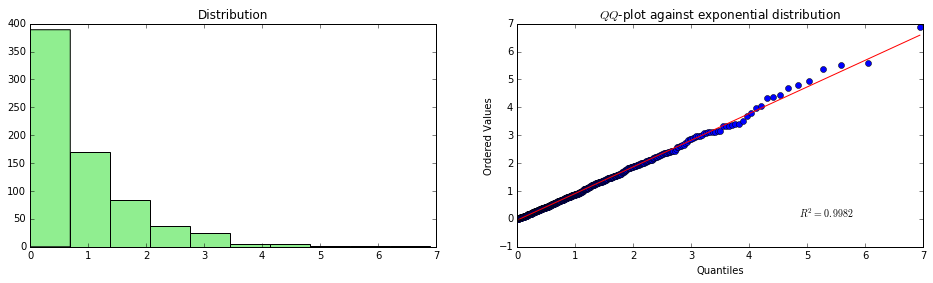

In [12]:
# QQ-plot
f, ax = plt.subplots(1, 2, figsize=(16,4))
ax[0].hist(Lamb1, color='lightgreen')
ax[0].set_title('Distribution')
stats.probplot(Lamb1, dist="expon", plot=ax[1])
ax[1].set_title('$QQ$-plot against exponential distribution')
plt.show()

**Remarque :** Le $QQ$-plot nous confirme que les $=\Lambda(t_i,t_{i+1})=\tau_{i+1}-\tau_i$ suivent une distribution exponentielle, intuitive après avoir tracé la distribution de $\tau_{i+1}-\tau_i$.

### Maximum-likelihood estimation

Le sujet nous donne que :
$$\ln{\cal L}(\{t_i\}_{i=1,\ldots,n})=−\mu t_n − \sum_{i=1}^n\frac{\alpha}{\beta}\left(1−e^{−\beta (t_n−t_i)}\right) + \sum_{i=1}^n\ln\left(\mu+\alpha A(i)\right).$$
C'est cette formule que nous implémentons ci-dessous.

In [13]:
def LL_Hawkes(t, mu=mu1, alpha=alpha1, beta=beta1, A=A1):
    n = len(t)-1
    temp1 = -mu*t[n]
    temp2 = -alpha/beta*np.array([1-np.exp(-beta*(t[n]-t[i])) for i in range(1,n-1)]).sum() 
    # (Le n-ieme terme de la seconde somme vaut en effet toujours 0)
    temp3 = np.array([np.log(mu+alpha*A[i]) for i in range(1,n)]).sum() 
    
    return temp1+temp2+temp3

#### Dépendance de `LL_Hawkes` en $\mu$

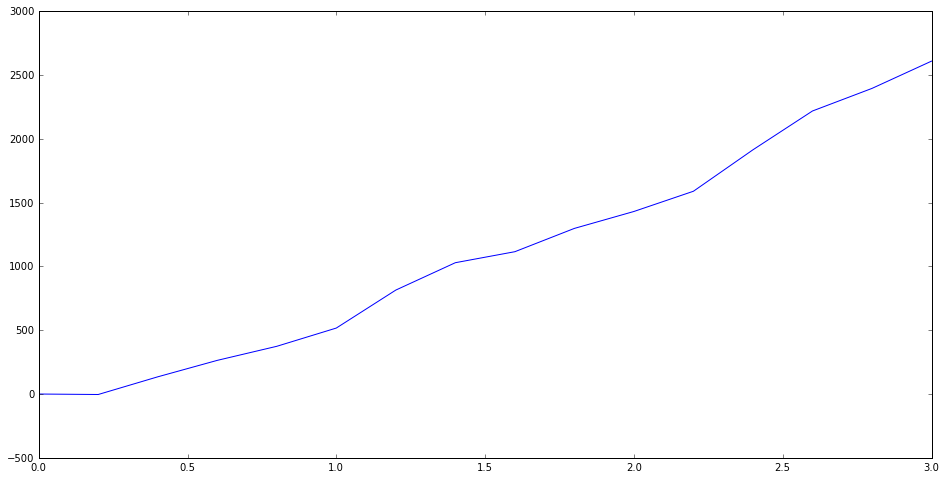

In [14]:
mu_l = np.linspace(0,3,16)
f, ax = plt.subplots(figsize=(16,8))
LL = []
for mu in mu_l:
    Proc = simHawkes(mu=mu)
    A = AFun(Proc)
    LL += [LL_Hawkes(Proc, mu=mu, A=A)]
ax.plot(mu_l, LL)
plt.show()

**Remarque :** Le log-likelihood `LL_Hawkes` augmente avec $\mu$.

#### Dépendance de `LL_Hawkes` en $\alpha$

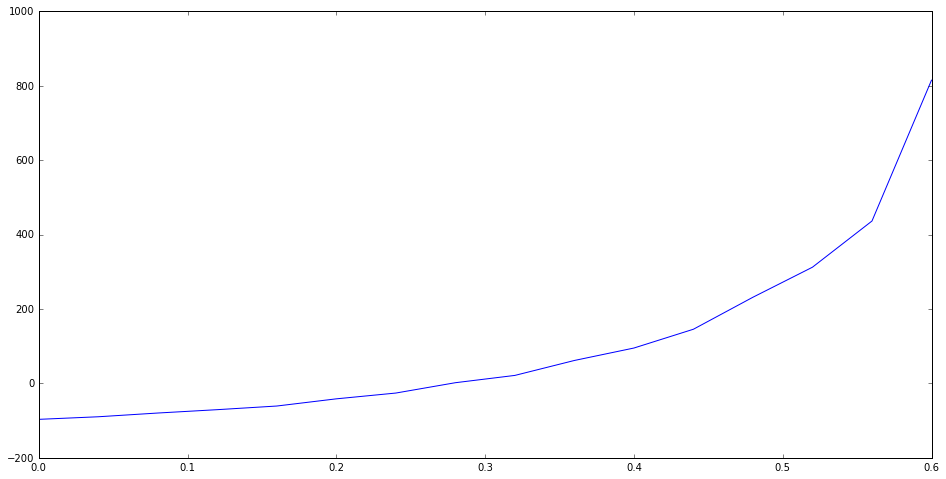

In [15]:
alpha_l = np.linspace(0.,0.6,16)
f, ax = plt.subplots(figsize=(16,8))
LL = []
for alpha in alpha_l:
    Proc = simHawkes(alpha=alpha)
    A = AFun(Proc)
    LL += [LL_Hawkes(Proc, alpha=alpha, A=A)]
ax.plot(alpha_l, LL)
plt.show()

**Remarque :** Le log-likelihood `LL_Hawkes` augmente avec $\alpha$.

#### Dépendance de `LL_Hawkes` en $\beta$

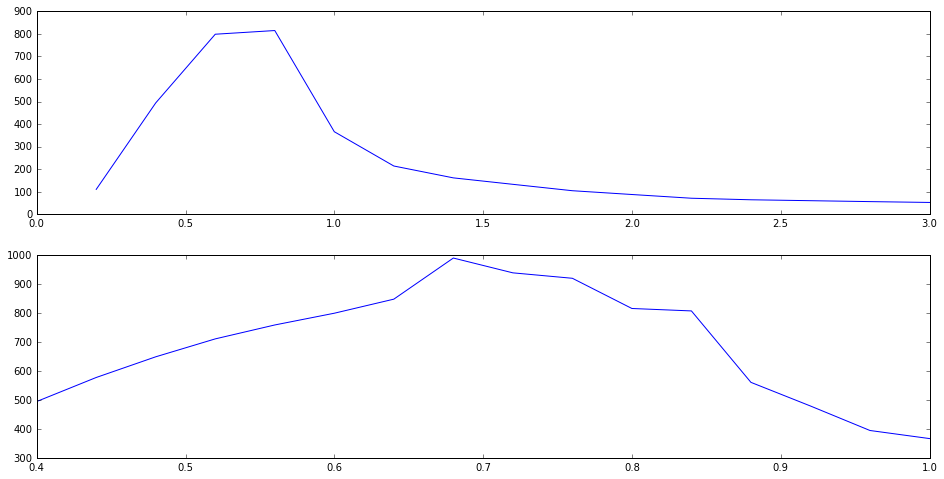

In [16]:
f, ax = plt.subplots(2, 1, figsize=(16,8))

beta_l1 = np.linspace(0,3,16)
LL1 = []
for beta in beta_l1:
    Proc = simHawkes(beta=beta)
    A = AFun(Proc, beta=beta)
    LL1 += [LL_Hawkes(Proc, beta=beta, A=A)]
ax[0].plot(beta_l1, LL1)

beta_l2 = np.linspace(0.4,1.,16)
LL2 = []
for beta in beta_l2:
    Proc = simHawkes(beta=beta)
    A = AFun(Proc, beta=beta)
    LL2 += [LL_Hawkes(Proc, beta=beta, A=A)]
ax[1].plot(beta_l2, LL2)

plt.show()

**Remarque :** Le _log-likelihood_ `LL_Hawkes` décroît avec $\beta$ à partir d'un certain rang, permettant d'atteindre le _Maximum Likelihood_ autour de $\beta=\beta_1=0.8$.

## II. Multidimensionnal Hawkes processes

## III. A one-dimensional price model